In [ ]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from matplotlib.backends.backend_pdf import PdfPages
import os
import datetime
from dataclasses import dataclass
from typing import List
import tarfile

run_num = 0

In [ ]:
cb_palette = sns.color_palette(as_cmap=True)

color_palette = {
    "Expected": cb_palette[0], 
    "expected": cb_palette[0], 
    "woltka": cb_palette[1], 
    "wol": cb_palette[1], 
    "jams": cb_palette[2], 
    "wgsa": cb_palette[3], 
    "wgsa2": cb_palette[3], 
    "biobakery3": cb_palette[4], 
    "bio3": cb_palette[4], 
    "biobakery4": cb_palette[5], 
    "bio4": cb_palette[5]
}

today = datetime.date.today()
date = today.strftime("%Y-%m-%d")

# Gathering and Generating Combined Stats Files

In [ ]:
project_root = os.path.abspath("../../pipelines/")
# threshold = 0.0

# First, we load the data from the CSV file.
def find_stats_files(rank: str, threshold: bool):
    for root, dirs, files in os.walk(project_root):
        for file in files:
            # print(file)
            if f"all_stats_replicates_{rank}" in file and file.endswith('.csv'):
                stats_path = os.path.join(root, file)

                df = pd.read_csv(stats_path)

                if threshold:
                    # Add the threshold to the dataframe
                    threshold = file.split("_")[0]
                    if threshold == "all":
                        continue
                    elif threshold == "0.1":
                        continue
                    else:   
                        df["threshold"] = threshold
                
                yield stats_path, df

In [ ]:
def combine_stats(rank: str, threshold_files: bool) -> pd.DataFrame:
    """
    Parameters:
        rank: str
            The rank to combine the stats for.
        threshold_files: bool
            Whether the files are thresholded or not.
    Returns:
        df: pd.DataFrame
            The combined dataframe.

    Combines the stats from all the different pipelines into one dataframe.
    """
    combined_df = pd.DataFrame()

    for path, df in find_stats_files(rank, threshold_files):
        df["Source"] = path.split("/")[-2]
        combined_df = pd.concat([combined_df, df])

    return combined_df

In [ ]:
def make_catplot(df: pd.DataFrame, id_var: str, src: str, plot_type: str, pdf_output: PdfPages, title: str):
    melted = df.melt(id_vars=["SampleID", id_var, "Source"], var_name="Metric", value_name="Value").dropna()
    # Cast value column to float
    melted["Value"] = melted["Value"].astype(float)

    ax = sns.catplot(data=melted, x=id_var, y="Value", col="Metric", col_wrap=3, kind=plot_type, sharey=False, palette=color_palette)
    ax.fig.suptitle(title, y=1.05)

    pdf_output.savefig(ax.figure, bbox_inches='tight', dpi=300)
    plt.close(ax.figure)

def plot_stats(df: pd.DataFrame, output_pdf: str):
    pdf_output = PdfPages(output_pdf)
    # display(df.head(30))
    for th, th_df in df.groupby("threshold"):
        for src, df in th_df.groupby("Source"):
            title = f'Summary of Statistics for {src} at {th} Threshold'
            if src == "bmock12" or src == "camisimGI" or src =="nist":
                make_catplot(df, "Pipeline", src, "bar", pdf_output, title)

            else:
                no_average = df.loc[df['SampleID'] != 'Average']
                make_catplot(no_average, "Pipeline", src, "box", pdf_output, title)

    pdf_output.close()

In [ ]:
def recode_pipeline(df: pd.DataFrame) -> pd.DataFrame:
    recode_dict = {"wgsa": "wgsa2", "wol": "woltka", "bio4": "biobakery4"}

    df["Pipeline"].replace(recode_dict, inplace=True)


def cleanup_combined_df(df: pd.DataFrame) -> pd.DataFrame:
    # display(df.head(30))
    # If the Pipeline value is empty, then replace it with the value in "Source/Pipeline".
    try:
        df.loc[df["Pipeline"].isna(), "Pipeline"] = df.loc[df["Pipeline"].isna(), "Source/Pipeline"]
        # Drop the "Source/Pipeline" column.
        df = df.drop(columns=["Source/Pipeline"])
    except KeyError:
        print("Warning: No Source/Pipeline column found. Skipping...")
        pass

    # Drop rows where the SampleID is "Average".
    df = df.loc[df["SampleID"] != "Average"]

    # Recode the pipeline names.
    recode_pipeline(df)

    return df

In [ ]:
# plot_stats(combine_stats("genus"), "stats_summary_genus.pdf")

def make_stats():
    # Check if today's files exist. If they do, we want to delete them because we are going to append to them.
    today_genus = f"results/all_stats_genus_{today}.csv"
    today_species = f"results/all_stats_species_{today}.csv"

    if os.path.exists(today_genus):
        os.remove(today_genus)
    if os.path.exists(today_species):
        os.remove(today_species)
    
    combined_df = cleanup_combined_df(combine_stats("genus", True))
    combined_df.to_csv(today_genus, index=False, mode='a')

    combined_df = cleanup_combined_df(combine_stats("species", True))
    combined_df.to_csv(today_species, index=False, mode='a')

make_stats()
# plot_stats(combined_df, "stats_summary_species.pdf")
# display(combined_df.head(30))

# Subset Plotting with Simple Bars

In [ ]:
@dataclass
class Subset:
    pipelines: List[str]
    thresholds: List[float]
    sources: List[str]
    metrics: List[str]

# Only gather stats of interest... no longer using jams202212 as of 2023-03-01.
replicates = Subset(
    pipelines = ["biobakery3", "biobakery4", "jams", "wgsa2", "woltka"],
    thresholds = [0.0001],
    sources = ["mixed", "hilo", "tourlousse"],
    metrics = ["AD", "Sens", "FPRA"],
)

one_to_one = Subset(
    pipelines = ["biobakery3", "biobakery4", "jams", "wgsa2", "woltka"],
    thresholds = [0.0001],
    sources = ["bmock12", "camisimGI", "nist"],
    metrics = ["AD", "Sens", "FPRA"],
)

rename_pipeline_dict = {
    "biobakery3": "Biobakery3", 
    "biobakery4": "Biobakery4", 
    "jams": "JAMS", 
    "wgsa2": "WGSA2", 
    "woltka": "Woltka"
}

rename_source_dict = {
    "mixed": "Amos Mixed",
    "hilo": "Amos HiLo",
    "tourlousse": "Tourlousse",
}

In [ ]:
# Open the stats files:
stats_files = [f"results/all_stats_species_{today}.csv", f"results/all_stats_genus_{today}.csv"]

def subset_df(sub: Subset, save: bool = False):
    for sf in stats_files:
        df = pd.read_csv(sf)
        # display(df)
        df = df.loc[df["Pipeline"].isin(sub.pipelines)]
        df = df.loc[df["threshold"].isin(sub.thresholds)]
        df = df.loc[df["Source"].isin(sub.sources)]
        df["Run"] = run_num

        if save:
            df.to_csv(f"{sf.split('.')[0]}_subset.csv", index=False)
        
        rank = sf.split("_")[2].split(".")[0]
    
        yield df, rank


def plot_subset(sub: Subset, tag: str, pdf_output: PdfPages):
    for df, rank in subset_df(sub, save=True):
        id_vars = ["SampleID", "Pipeline", "Source"] + sub.metrics
        df = df[["SampleID", "Pipeline", "Source", "AD", "Sens", "FPRA"]]
        # display(df)
        df = df.melt(id_vars=["SampleID", "Pipeline", "Source"], var_name="Metrics", value_vars=["AD", "Sens", "FPRA"])

        # Rename the pipelines.
        df["Pipeline"].replace(rename_pipeline_dict, inplace=True)

        # We need to make a figure object no bigger than 8.5x11 inches.
        if tag == "One-to-One":
            # df["Community"] = df["SampleID"] + "_" + df["Source"]
            # g = sns.catplot(data=df, kind="bar", x="Pipeline", col="Metrics", row="Source", y="value", hue="Community")

            for src, src_df in df.groupby("Source"):
                print(src)
                g = sns.catplot(data=src_df, kind="bar", x="Pipeline", col="Metrics", y="value", hue="SampleID", sharey=True)
                # Change y-axis label to "Assessment Metric"
                g.set(ylabel="Assessment Metric")
                g.fig.suptitle(f"Summary of {rank.capitalize()} Stats for {src} Community", y=1.025)

                # Add data labels
                # for ax in g.axes.flat:
                #     for p in ax.patches:
                #         ax.annotate(f"{p.get_height():.0f}", (p.get_x() + p.get_width() / 2., p.get_height()),
                #             ha='center', va='center', xytext=(0, 10), textcoords='offset points')

                g.fig.savefig(f"results/images/{rank}_stats_{src}.png", bbox_inches='tight', dpi=300) 
                pdf_output.savefig(g.fig, bbox_inches='tight', dpi=300)
                plt.close(g.fig)

            # df["Community"] = df["SampleID"] + "_" + df["Source"]
            # g = sns.catplot(data=df, kind="bar", x="Pipeline", col="Metrics", row="Community", y="value", hue="Source") -- original
            # g = sns.catplot(data=df, kind="bar", x="Pipeline", col="Community", y="value", hue="Metrics", col_wrap=3)
            # g = sns.catplot(data=df, kind="bar", x="Pipeline", col="Source", row="SampleID", y="value", hue="Metrics", sharey=False)

        else:
            # Rname the sources.
            df["Source"].replace(rename_source_dict, inplace=True)
            g = sns.catplot(data=df, kind="bar", x="Pipeline", col="Metrics", y="value", hue="Source", sharey=True)


        g.fig.suptitle(f"Summary of {rank.capitalize()} Stats for {tag} Communities", y=1.05)
        g.set(ylabel="Assessment Metric")

        # Add data labels
        # for ax in g.axes.flat:
        #     for p in ax.patches:
        #         ax.annotate(f"{p.get_height():.0f}", (p.get_x() + p.get_width() / 2., p.get_height()),
        #                     ha='center', va='center', xytext=(0, 10), textcoords='offset points', fontsize=6)

        # save to png as well
        g.fig.savefig(f"results/images/{rank}_stats_{tag}.png", bbox_inches='tight', dpi=300) 
        pdf_output.savefig(g.fig, bbox_inches='tight', dpi=300)
        plt.close(g.fig)

In [ ]:
def tar_images():
    if len(os.listdir("results/images")) == 0:
        return

    with tarfile.open(f"results/images.tar.gz", "w:gz") as tar:
        tar.add("results/images", arcname=os.path.basename("results/images"))
    
    # Clear the images in the directory
    for f in os.listdir("results/images"):
        os.remove(os.path.join("results/images", f))

In [ ]:
pdf_output = PdfPages(f"results/summary_stats_{today}.pdf")
plot_subset(sub=replicates, tag="Replicate", pdf_output=pdf_output)
plot_subset(sub=one_to_one, tag="One-to-One", pdf_output=pdf_output)

# tar_images()

pdf_output.close()

In [ ]:
tar_images()

# Making Boxplots for Total Score

In [ ]:
import openpyxl
from statannotations.Annotator import Annotator
from itertools import combinations
from scipy.stats import f_oneway, kruskal, wilcoxon
from statsmodels.sandbox.stats.multicomp import multipletests


wanted_sheets = ["AD_Tidy", "Sens_Tidy", "FPRA_Tidy"]

score_table = pd.read_excel("../paper/ad_table.xlsx", sheet_name=wanted_sheets)
for df in score_table.values():
    display(df.head())

In [ ]:
def cleanup_df(df: pd.DataFrame):
    """ Takes input of corrected p-values and returns a dataframe with correct rounding and bolding."""

    # If val < 0.05, then it is significant and it should be bolded. If it is "-", then is should be left alone.
    df = df.style.applymap(lambda val: "font-weight: bold" if float(val) < 0.05 else "")

    display(df)
    return df
    

AD_Tidy


,Community,Biobakery3,Biobakery4,JAMS,WGSA2,Woltka
0,Bmock12,16.6180,11.3065,22.3681,24.4673,26.4484
1,CamiSim-S1,8.6188,12.7647,15.0361,13.4764,30.7596
2,CamiSim-S2,1.2308,7.1138,4.8525,6.3786,25.8766
3,NIST-EG,10.1826,8.9446,12.2531,10.6638,22.5953
4,NIST-MIX-A,9.5852,2.8426,12.3527,6.9975,19.2420


Kruskal-Wallis:  29.669185360094474 5.715117373400621e-06
AD_Tidy


,Community,Biobakery3,Biobakery4,JAMS,WGSA2,Woltka
0,Bmock12,16.6180,11.3065,22.3681,24.4673,26.4484
1,CamiSim-S1,8.6188,12.7647,15.0361,13.4764,30.7596
2,CamiSim-S2,1.2308,7.1138,4.8525,6.3786,25.8766
3,NIST-EG,10.1826,8.9446,12.2531,10.6638,22.5953
4,NIST-MIX-A,9.5852,2.8426,12.3527,6.9975,19.2420


p-val
Biobakery4 Biobakery3  0.083008
JAMS       Biobakery3  0.041992
           Biobakery4  0.001953
WGSA2      Biobakery3  0.032227
           Biobakery4  0.002930
           JAMS        0.764648
Woltka     Biobakery3  0.000977
           Biobakery4  0.000977
           JAMS        0.000977
           WGSA2       0.000977

,Biobakery3,Biobakery4,JAMS,WGSA2
Biobakery4,0.092231,nan,nan,nan
JAMS,0.052490,0.003906,nan,nan
WGSA2,0.046038,0.004883,0.764648,nan
Woltka,0.002441,0.002441,0.002441,0.002441


,Community,SampleID,AD
0,Bmock12,Biobakery3,16.6180
1,CamiSim-S1,Biobakery3,8.6188
2,CamiSim-S2,Biobakery3,1.2308
3,NIST-EG,Biobakery3,10.1826
4,NIST-MIX-A,Biobakery3,9.5852


array(['Biobakery3', 'Biobakery4', 'JAMS', 'WGSA2', 'Woltka'],
      dtype=object)

p-value annotation legend:
      ns: p <= 1.00e+00
       *: 1.00e-02 < p <= 5.00e-02
      **: 1.00e-03 < p <= 1.00e-02
     ***: 1.00e-04 < p <= 1.00e-03
    ****: p <= 1.00e-04

Biobakery3 vs. Biobakery4: Wilcoxon test (paired samples), P_val:8.301e-02 Stat=1.300e+01
Biobakery4 vs. JAMS: Wilcoxon test (paired samples), P_val:1.953e-03 Stat=1.000e+00
JAMS vs. WGSA2: Wilcoxon test (paired samples), P_val:7.646e-01 Stat=2.900e+01
WGSA2 vs. Woltka: Wilcoxon test (paired samples), P_val:9.766e-04 Stat=0.000e+00
Biobakery3 vs. JAMS: Wilcoxon test (paired samples), P_val:4.199e-02 Stat=1.000e+01
Biobakery4 vs. WGSA2: Wilcoxon test (paired samples), P_val:2.930e-03 Stat=2.000e+00
JAMS vs. Woltka: Wilcoxon test (paired samples), P_val:9.766e-04 Stat=0.000e+00
Biobakery3 vs. WGSA2: Wilcoxon test (paired samples), P_val:3.223e-02 Stat=9.000e+00
Biobakery4 vs. Woltka: Wilcoxon test (paired samples), P_val:9.766e-04 Stat=0.000e+00
Biobakery3 vs. Woltka: Wilcoxon test (paired samples), P_val:9.76

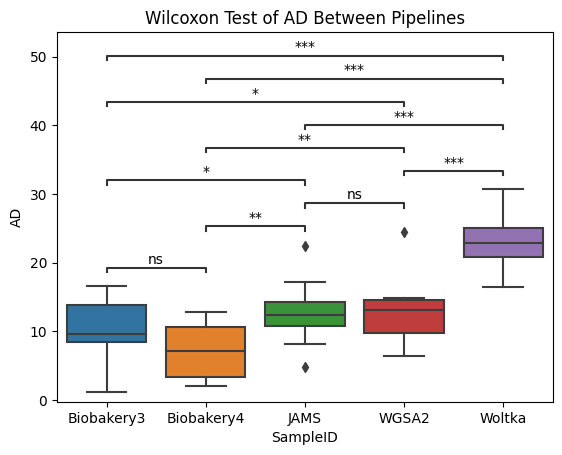

Sens_Tidy


,Community,Biobakery3,Biobakery4,JAMS,WGSA2,Woltka
0,Bmock12,36.3636,63.6364,54.5455,45.4545,9.0909
1,CamiSim-S1,100.0000,89.4737,97.3684,97.3684,86.8421
2,CamiSim-S2,100.0000,95.2381,100.0000,100.0000,80.9524
3,NIST-EG,85.7143,92.8571,92.8571,100.0000,85.7143
4,NIST-MIX-A,81.8182,90.9091,72.7273,100.0000,90.9091


Kruskal-Wallis:  7.055591314294873 0.13297948031797943
Sens_Tidy


,Community,Biobakery3,Biobakery4,JAMS,WGSA2,Woltka
0,Bmock12,36.3636,63.6364,54.5455,45.4545,9.0909
1,CamiSim-S1,100.0000,89.4737,97.3684,97.3684,86.8421
2,CamiSim-S2,100.0000,95.2381,100.0000,100.0000,80.9524
3,NIST-EG,85.7143,92.8571,92.8571,100.0000,85.7143
4,NIST-MIX-A,81.8182,90.9091,72.7273,100.0000,90.9091


/Users/valenciaem/coding/pipelines/.pipeline_venv/lib/python3.10/site-packages/scipy/stats/_morestats.py:3145: UserWarning: Exact p-value calculation does not work if there are ties. Switching to normal approximation.
  warnings.warn("Exact p-value calculation does not work if there are "
/Users/valenciaem/coding/pipelines/.pipeline_venv/lib/python3.10/site-packages/scipy/stats/_morestats.py:3159: UserWarning: Sample size too small for normal approximation.
  warnings.warn("Sample size too small for normal approximation.")


p-val
Biobakery4 Biobakery3  0.106897
JAMS       Biobakery3  0.028006
           Biobakery4  0.372577
WGSA2      Biobakery3  0.020767
           Biobakery4  0.413086
           JAMS        0.593306
Woltka     Biobakery3  0.858955
           Biobakery4  0.766898
           JAMS        0.153042
           WGSA2       0.013672

,Biobakery3,Biobakery4,JAMS,WGSA2
Biobakery4,0.267242,nan,nan,nan
JAMS,0.093355,0.590123,nan,nan
WGSA2,0.093355,0.590123,0.741632,nan
Woltka,0.858955,0.852109,0.306084,0.093355


,Community,SampleID,Sens
0,Bmock12,Biobakery3,36.3636
1,CamiSim-S1,Biobakery3,100.0000
2,CamiSim-S2,Biobakery3,100.0000
3,NIST-EG,Biobakery3,85.7143
4,NIST-MIX-A,Biobakery3,81.8182


array(['Biobakery3', 'Biobakery4', 'JAMS', 'WGSA2', 'Woltka'],
      dtype=object)

p-value annotation legend:
      ns: p <= 1.00e+00
       *: 1.00e-02 < p <= 5.00e-02
      **: 1.00e-03 < p <= 1.00e-02
     ***: 1.00e-04 < p <= 1.00e-03
    ****: p <= 1.00e-04

Biobakery3 vs. Biobakery4: Wilcoxon test (paired samples), P_val:1.069e-01 Stat=6.500e+00
Biobakery4 vs. JAMS: Wilcoxon test (paired samples), P_val:3.726e-01 Stat=1.500e+01
JAMS vs. WGSA2: Wilcoxon test (paired samples), P_val:5.933e-01 Stat=1.800e+01


/Users/valenciaem/coding/pipelines/.pipeline_venv/lib/python3.10/site-packages/scipy/stats/_morestats.py:3145: UserWarning: Exact p-value calculation does not work if there are ties. Switching to normal approximation.
  warnings.warn("Exact p-value calculation does not work if there are "
/Users/valenciaem/coding/pipelines/.pipeline_venv/lib/python3.10/site-packages/scipy/stats/_morestats.py:3159: UserWarning: Sample size too small for normal approximation.
  warnings.warn("Sample size too small for normal approximation.")


WGSA2 vs. Woltka: Wilcoxon test (paired samples), P_val:1.367e-02 Stat=6.000e+00
Biobakery3 vs. JAMS: Wilcoxon test (paired samples), P_val:2.801e-02 Stat=6.000e+00
Biobakery4 vs. WGSA2: Wilcoxon test (paired samples), P_val:4.131e-01 Stat=2.300e+01
JAMS vs. Woltka: Wilcoxon test (paired samples), P_val:1.530e-01 Stat=1.350e+01
Biobakery3 vs. WGSA2: Wilcoxon test (paired samples), P_val:2.077e-02 Stat=3.000e+00
Biobakery4 vs. Woltka: Wilcoxon test (paired samples), P_val:7.669e-01 Stat=2.000e+01
Biobakery3 vs. Woltka: Wilcoxon test (paired samples), P_val:8.590e-01 Stat=2.100e+01


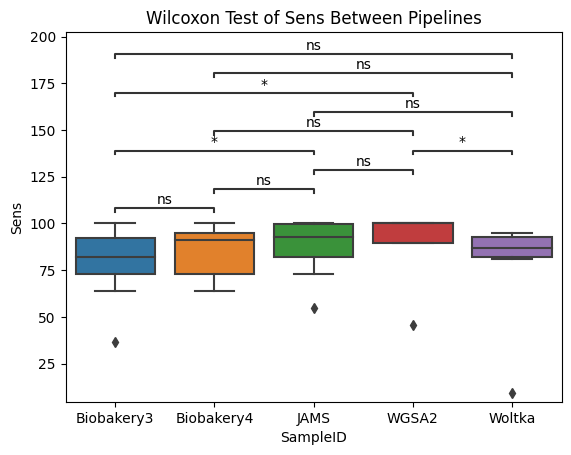

FPRA_Tidy


,Community,Biobakery3,Biobakery4,JAMS,WGSA2,Woltka
0,Bmock12,2.6303,17.9266,50.0438,37.3443,11.9647
1,CamiSim-S1,0.5265,3.0566,1.4388,2.0432,8.5091
2,CamiSim-S2,0.0586,3.8344,0.2055,3.9102,30.6668
3,NIST-EG,2.6645,0.0000,0.2104,1.1601,26.4802
4,NIST-MIX-A,0.8464,0.0000,0.0520,0.6781,30.9152


Kruskal-Wallis:  17.239749352055348 0.0017362226109084878
FPRA_Tidy


,Community,Biobakery3,Biobakery4,JAMS,WGSA2,Woltka
0,Bmock12,2.6303,17.9266,50.0438,37.3443,11.9647
1,CamiSim-S1,0.5265,3.0566,1.4388,2.0432,8.5091
2,CamiSim-S2,0.0586,3.8344,0.2055,3.9102,30.6668
3,NIST-EG,2.6645,0.0000,0.2104,1.1601,26.4802
4,NIST-MIX-A,0.8464,0.0000,0.0520,0.6781,30.9152


p-val
Biobakery4 Biobakery3  0.700195
JAMS       Biobakery3  0.965820
           Biobakery4  0.464844
WGSA2      Biobakery3  0.413086
           Biobakery4  0.123047
           JAMS        0.320312
Woltka     Biobakery3  0.000977
           Biobakery4  0.002930
           JAMS        0.041992
           WGSA2       0.018555

,Biobakery3,Biobakery4,JAMS,WGSA2
Biobakery4,0.777995,nan,nan,nan
JAMS,0.965820,0.581055,nan,nan
WGSA2,0.581055,0.246094,0.533854,nan
Woltka,0.009766,0.014648,0.104980,0.061849


,Community,SampleID,FPRA
0,Bmock12,Biobakery3,2.6303
1,CamiSim-S1,Biobakery3,0.5265
2,CamiSim-S2,Biobakery3,0.0586
3,NIST-EG,Biobakery3,2.6645
4,NIST-MIX-A,Biobakery3,0.8464


array(['Biobakery3', 'Biobakery4', 'JAMS', 'WGSA2', 'Woltka'],
      dtype=object)

p-value annotation legend:
      ns: p <= 1.00e+00
       *: 1.00e-02 < p <= 5.00e-02
      **: 1.00e-03 < p <= 1.00e-02
     ***: 1.00e-04 < p <= 1.00e-03
    ****: p <= 1.00e-04

Biobakery3 vs. Biobakery4: Wilcoxon test (paired samples), P_val:7.002e-01 Stat=2.800e+01
Biobakery4 vs. JAMS: Wilcoxon test (paired samples), P_val:4.648e-01 Stat=2.400e+01
JAMS vs. WGSA2: Wilcoxon test (paired samples), P_val:3.203e-01 Stat=2.100e+01
WGSA2 vs. Woltka: Wilcoxon test (paired samples), P_val:1.855e-02 Stat=7.000e+00
Biobakery3 vs. JAMS: Wilcoxon test (paired samples), P_val:9.658e-01 Stat=3.200e+01
Biobakery4 vs. WGSA2: Wilcoxon test (paired samples), P_val:1.230e-01 Stat=1.500e+01
JAMS vs. Woltka: Wilcoxon test (paired samples), P_val:4.199e-02 Stat=1.000e+01
Biobakery3 vs. WGSA2: Wilcoxon test (paired samples), P_val:4.131e-01 Stat=2.300e+01
Biobakery4 vs. Woltka: Wilcoxon test (paired samples), P_val:2.930e-03 Stat=2.000e+00
Biobakery3 vs. Woltka: Wilcoxon test (paired samples), P_val:9.76

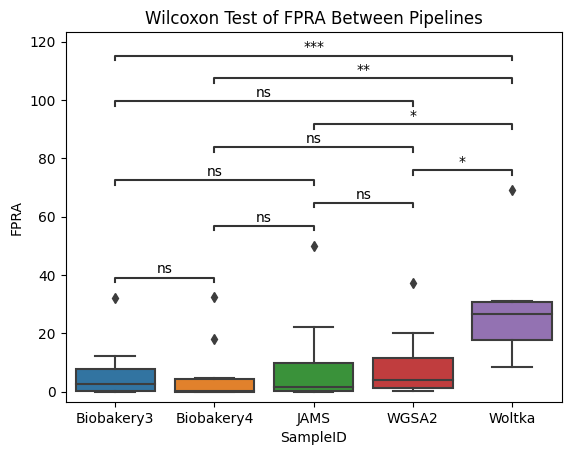

In [14]:
def annontated_boxplot(stat: str):
    # We need to convert to tidy format.
    name = stat.split("_")[0]
    AD = score_table[stat].melt(id_vars=["Community"], var_name="SampleID", value_name=name)

    display(AD.head())
    # Get unique values in SampleID column
    pipelines = AD["SampleID"].unique()
    display(pipelines)

    # Make a list of tuples of all pairs of pipelines
    pairs = list(combinations(pipelines, 2))

    # Boxplot of AD
    g = sns.boxplot(data=AD, x="SampleID", y=name)

    ann = Annotator(g, pairs, data=AD, x="SampleID", y=name)
    ann.configure(test="Wilcoxon", text_format="star", loc="inside", verbose=2)
    ann.apply_and_annotate()

    g.set_title(f"Wilcoxon Test of {name} Between Pipelines")

    plt.savefig(f"results/stats_tex/{name}_boxplot.png", bbox_inches='tight', dpi=300)

    plt.show()

def pairwise_analysis(df: pd.DataFrame, stat: str):
    print(stat)
    stat_short = stat.split("_")[0]
    values_df = df[stat]
    display(values_df.head())

    # Get the columns, drop the community column
    pipelines = values_df.columns[1:]

    # Make a dataframe of the values on both the x and y axis
    a = pd.DataFrame(np.zeros((len(pipelines), len(pipelines))), index=pipelines, columns=pipelines)

    # Make a list of tuples of all pairs of pipelines
    pairs = list(combinations(pipelines, 2))

    # Now do Wilcoxon on all the pairs
    for pair in pairs:
        h, p = wilcoxon(values_df[pair[0]], values_df[pair[1]], correction=False)
        a.loc[pair[1], pair[0]] = p

    # Fill 0 with "nan"
    a = a.replace(0, np.NAN)

    # Flatten a to a 1D array
    b = pd.DataFrame(a.stack(), columns=["p-val"])

    display(b)

    # Apply the Bonferroni correction
    b_corrected = multipletests(b["p-val"], method="fdr_bh")

    b["corrected_p-val"] = b_corrected[1]
    b.drop("p-val", axis=1, inplace=True)

    # Reshape b to a square matrix
    b = b.unstack()
    b = b.droplevel(0, axis=1)

    b = cleanup_df(b)

    caption = f"Pairwise Wilcoxon test for {stat_short} between all pipelines. The FDR-BH corrected p-values are shown in the table. Bold values indicate < 0.05."
    label = f"tab:pairwise_{stat_short}"
    b.to_latex(f"results/stats_tex/{stat_short}_pairwise.tex", convert_css=True, caption=caption, label=label)


def group_analysis(df: pd.DataFrame, stat: str):
    print(stat)
    values_df = df[stat]
    display(values_df.head())
    # f, p = f_oneway(values_df["Biobakery4"], values_df["Biobakery3"], values_df["JAMS"], values_df["WGSA2"], values_df["Woltka"])
    # print(f, p)

    # Now do Kruskal-Wallis
    h, p = kruskal(values_df["Biobakery4"], values_df["Biobakery3"], values_df["JAMS"], values_df["WGSA2"], values_df["Woltka"])
    print("Kruskal-Wallis: ", h, p)
    return h,p


def do_group_stats():
    stats = []
    for stat in wanted_sheets:
        h, p = group_analysis(score_table, stat)
        stats.append([stat, h, p])

        pairwise_analysis(score_table, stat)
        annontated_boxplot(stat)

    stats_df = pd.DataFrame(stats, columns=["Stat", "H", "P"])
    stats_df.to_csv("kw_results.csv", index=False)


do_group_stats()